# Partition of Unity 

To speed up the code, the domain is split into circular regions using kd trees. The interpolation is performed in each region separately and then stitched together with a smooth weighting function 

#### Steps in the algorithm:


generate data points 

generate evaluation points 

generate sites for the covering

generate weights matrix for the evaluation points using shepards method 
- construct N_eval x N_pu sparce matrix based on partition weighting function 
- normalize the entries of the matrix such that it satisfies the weight function requirement 

create kd tree for data points 

create kd tree for evaluation points 

for Partition region i:
- find all data points within specified radius 
- build interpolation matrix on these points 
- calculate interpolating coefficients 
- find all evaluation points within specified radius 
- calculare evaluation matrix 
- calculate local interpolation 
- multiply all points in ith partition region by their shepard weight function 
- add the contributions to the corresponding evaluation points 



In [30]:
include("RBFunctions.jl")
using GLMakie
using CairoMakie
GLMakie.activate!()

In [31]:
function sparce_distance_matrix(data1,data2,r_max)
    #build k-d tree
    small = 0.00000000001
    m = size(data1)[2]
    n = size(data2)[2]
    A = spzeros(m,n)
    if m>=n
        tree = KDTree(data1,Euclidean(),leafsize = 3)
        for j in 1:n
            point = data2[:,j]
            idxs = inrange(tree, point, r_max, true)
            A[idxs,j] = vec(max.(pairwise(Euclidean(),point[:,:], data1[:,idxs]),small))
        end
        return A
    else
        print("asas")
        tree = KDTree(data2,Euclidean(),leafsize = 3)
        for j in 1:m
            point = data1[:,j]
            idxs = inrange(tree, point, r_max, true)
            A[j,idxs] = vec(max.(pairwise(Euclidean(),point[:,:], data2[:,idxs]),small))
        end
        return A 
    end

end

sparce_distance_matrix (generic function with 1 method)

In [32]:
function wendland_C2(r::Real,ϵ)
    if r/ϵ >= 0.0 && r/ϵ <=1.0
        return ((1-r/ϵ)^4) * (4r/ϵ+1)
    else 
        return 0.0
    end
end

function wendland_C2!(M::SparseMatrixCSC,ϵ)
    for i in 1:length(M.nzval)
        M.nzval[i] =  wendland_C2(M.nzval[i],ϵ)
    end
end

function shepard_matrix!(M::SparseMatrixCSC)
    #turn weighted distance matrix into shepard matrix 
    a = sum(M,dims = 2)
    #println(length(M.nzval))
    for i in 1:length(M.nzval)
        #println(i)
        #println(a[M.rowval[i]])
        M.nzval[i] = M.nzval[i]/(a[M.rowval[i]])
    end
end

shepard_matrix! (generic function with 1 method)

In [33]:

#----------------set up the problem -------
N_data = 3000
N_eval = 200
N_pu = 16
radius = 1/(N_pu-1)
d_sites = generate_2D_Halton_points(N_data)
x = collect(LinRange(0,1,N_eval))
eval_sites_x = ones(N_eval) * x'
eval_sites_y =  x * ones(N_eval)' 
eval_sites = hcat(vec(eval_sites_x),vec(eval_sites_y))'
xx = collect(LinRange(0,1,N_pu))
pu_sites = hcat(vec(ones(N_pu) * xx'),vec(xx * ones(N_pu)'))'
f_data = frankes_func.(d_sites[1,:],d_sites[2,:])
f_eval = frankes_func.(eval_sites[1,:],eval_sites[2,:])

#---------Compute interpolation------------------
SM = sparce_distance_matrix(eval_sites,pu_sites,radius)
wendland_C2!(SM,radius)
shepard_matrix!(SM)

tree_data = KDTree(d_sites,Euclidean(),leafsize = 3)
tree_eval = KDTree(eval_sites,Euclidean(),leafsize = 3)
rr = 0.5 # shape parameter of RBF
globalfit = zeros(Float64,size(eval_sites)[2])
for i in 1:N_pu^2
    idxs_data = inrange(tree_data, pu_sites[:,i], radius, true)
    DM_data = pairwise(Euclidean(), d_sites[:,idxs_data], d_sites[:,idxs_data], dims=2)
    IM =  wendland_C2.(DM_data,rr) # apply RBF to a distance matrix
    c = inv(IM)*f_data[idxs_data]
    idxs_eval = inrange(tree_eval, pu_sites[:,i], radius, true)
    DM_eval = pairwise(Euclidean(), eval_sites[:,idxs_eval], d_sites[:,idxs_data], dims=2)
    EM = wendland_C2.(DM_eval,rr)
    localfit = EM*c
    #println(idxs_eval)
    globalfit[idxs_eval] = globalfit[idxs_eval] + localfit .* SM[idxs_eval,i]
end


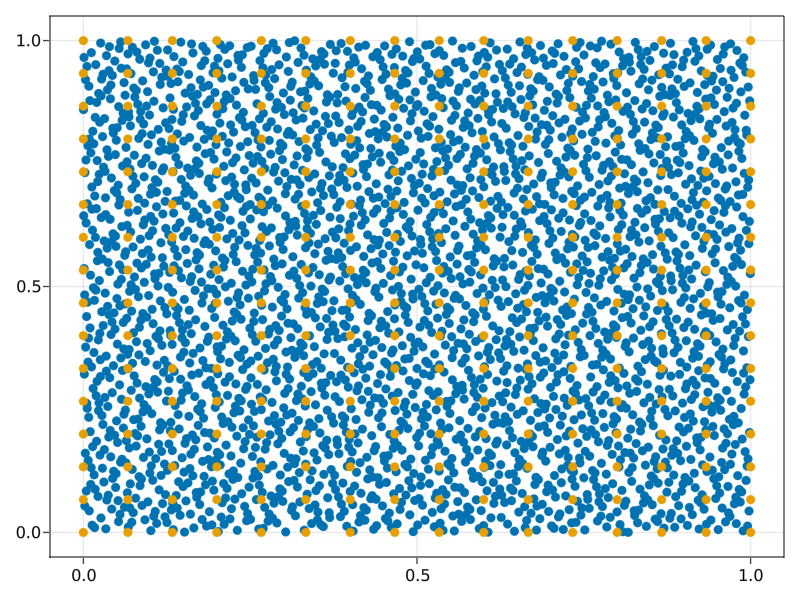

In [34]:
#------------Plot--------------------

f1 = Figure()
ax = Axis(f1[1, 1])
#scatter!(ax,eval_sites[1,:],eval_sites[2,:])
scatter!(ax,d_sites[1,:],d_sites[2,:])
scatter!(ax,pu_sites[1,:],pu_sites[2,:])
f1

### Blue: data sites ; Orange: centers of patches 

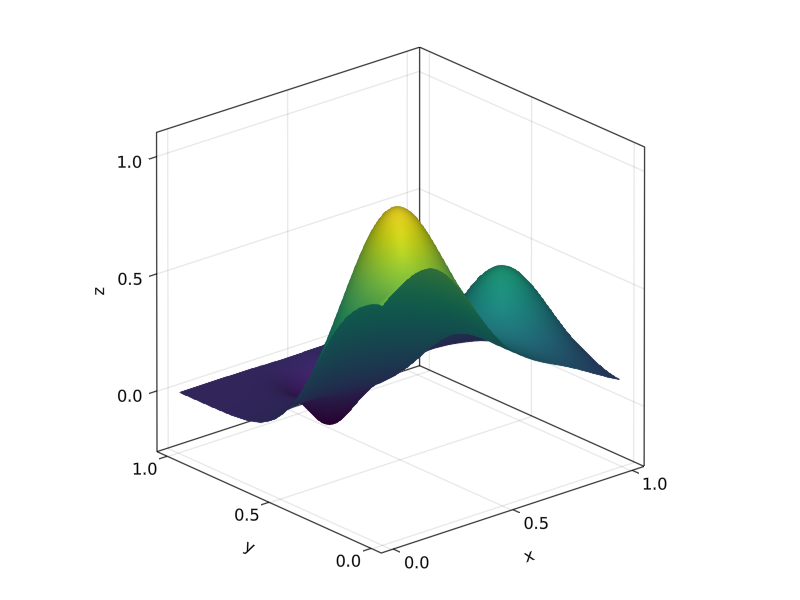

In [35]:
f = Figure()
ax = Axis3(f[1, 1]; aspect=(1, 1, 1))
surface!(ax,eval_sites[1,:],eval_sites[2,:],globalfit)
f


### Reconstructed function

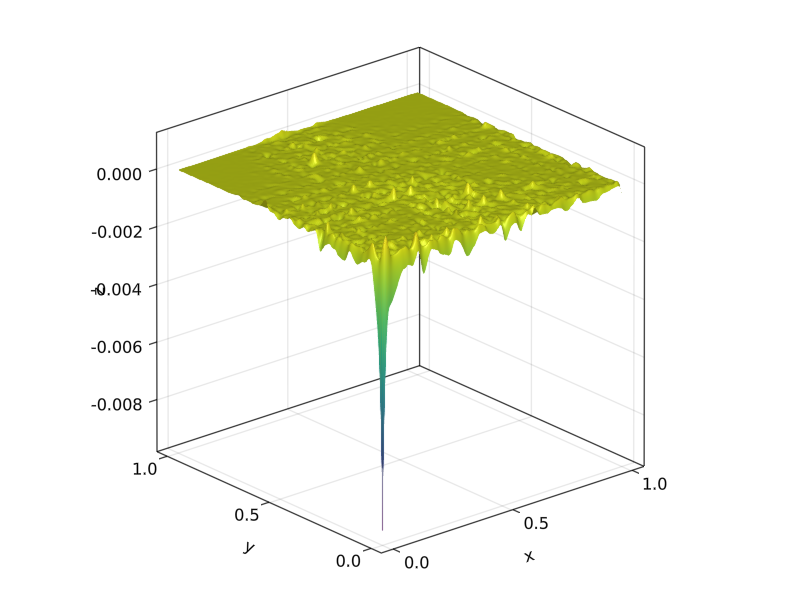

In [36]:
f2 = Figure()
ax2 = Axis3(f2[1, 1]; aspect=(1, 1, 1))
surface!(ax2,eval_sites[1,:],eval_sites[2,:],globalfit-f_eval)
f2

### Error plot